# Testing tensor compression layers
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [1]:
import os
import errno

import numpy as np

import deepcell

Using TensorFlow backend.


### Load the Training Data

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (6208, 216, 256, 1)
y.shape: (6208, 216, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [5]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'conv_fgbg_model'
conv_model_name = 'conv_watershed_model'

n_epoch = 1  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 0  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'watershed'
distance_bins = 4
erosion_width = 0  # erode edges

### First, create a foreground/background separation model

#### Instantiate the fgbg model

In [6]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(X_train.shape[1:]),
    last_only=False)

fgbg_clone = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(X_train.shape[1:]),
    last_only=False)

#### Train the model fgbg model

In [7]:
from deepcell.training import train_model_conv

fgbg_model = train_model_conv(
    model=fgbg_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=fgbg_model_name,
    test_size=test_size,
    optimizer=optimizer,
    n_epoch=n_epoch,
    num_gpus=1,
    batch_size=batch_size,
    transform='fgbg',
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

fgbg_clone.set_weights(fgbg_model.get_weights())

X_train shape: (6984, 216, 256, 1)
y_train shape: (6984, 216, 256, 1)
X_test shape: (776, 216, 256, 1)
y_test shape: (776, 216, 256, 1)
Output Shape: (None, 216, 256, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/1
6982/6984 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9508
Epoch 00001: val_loss improved from inf to 0.07564, saving model to /data/models/conv_fgbg_model.h5
6984/6984 [==============================] - 337s 48ms/step - loss: 0.0455 - acc: 0.9508 - val_loss: 0.0756 - val_acc: 0.9796


### Next, create the tensor compression layers in the notebook so they can be debugged

In [12]:
import numpy as np
from scipy.sparse.linalg import svds
from scipy.optimize import minimize_scalar

def VBMF(Y, cacb, sigma2=None, H=None):
    """Implementation of the analytical solution to Variational Bayes Matrix Factorization.
    This function can be used to calculate the analytical solution to VBMF. 
    This is based on the paper and MatLab code by Nakajima et al.:
    "Global analytic solution of fully-observed variational Bayesian matrix factorization."
    Notes
    -----
        If sigma2 is unspecified, it is estimated by minimizing the free energy.
        If H is unspecified, it is set to the smallest of the sides of the input Y.
        To estimate cacb, use the function EVBMF().
    Attributes
    ----------
    Y : numpy-array
        Input matrix that is to be factorized. Y has shape (L,M), where L<=M.
        
    cacb : int
        Product of the prior variances of the matrices that factorize the input.
    
    sigma2 : int or None (default=None)
        Variance of the noise on Y.
        
    H : int or None (default = None)
        Maximum rank of the factorized matrices.
        
    Returns
    -------
    U : numpy-array
        Left-singular vectors. 
        
    S : numpy-array
        Diagonal matrix of singular values.
        
    V : numpy-array
        Right-singular vectors.
        
    post : dictionary
        Dictionary containing the computed posterior values.
        
        
    References
    ----------
    .. [1] Nakajima, Shinichi, et al. "Global analytic solution of fully-observed variational Bayesian matrix factorization." Journal of Machine Learning Research 14.Jan (2013): 1-37.
    
    .. [2] Nakajima, Shinichi, et al. "Perfect dimensionality recovery by variational Bayesian PCA." Advances in Neural Information Processing Systems. 2012.
    """    
    
    L,M = Y.shape #has to be L<=M

    if H is None:
        H = L
    
    #SVD of the input matrix, max rank of H
    U,s,V = np.linalg.svd(Y)
    U = U[:,:H]
    s = s[:H]
    V = V[:H].T 

    #Calculate residual
    residual = 0.
    if H<L:
        residual = np.sum(np.sum(Y**2)-np.sum(s**2))

    #Estimation of the variance when sigma2 is unspecified
    if sigma2 is None: 
        upper_bound = (np.sum(s**2)+ residual)/(L+M)

        if L==H: 
            lower_bound = s[-1]**2/M
        else:
            lower_bound = residual/((L-H)*M)

        sigma2_opt = minimize_scalar(VBsigma2, args=(L,M,cacb,s,residual), bounds=[lower_bound, upper_bound], method='Bounded')
        sigma2 = sigma2_opt.x
        #print("Estimated sigma2: ", sigma2)

    #Threshold gamma term
    #Formula above (21) from [1]
    thresh_term = (L+M + sigma2/cacb**2)/2 
    threshold = np.sqrt( sigma2 * (thresh_term + np.sqrt(thresh_term**2 - L*M) ))
              
    #Number of singular values where gamma>threshold
    pos = np.sum(s>threshold)

    #Formula (10) from [2]
    d = np.multiply(s[:pos], 
                    1 - np.multiply(sigma2/(2*s[:pos]**2),
                                    L+M+np.sqrt( (M-L)**2 + 4*s[:pos]**2/cacb**2 )))

    #Computation of the posterior
    post = {}
    zeta = sigma2/(2*L*M) * (L+M+sigma2/cacb**2 - np.sqrt((L+M+sigma2/cacb**2)**2 - 4*L*M))
    post['ma'] = np.zeros(H) 
    post['mb'] = np.zeros(H)
    post['sa2'] = cacb * (1-L*zeta/sigma2) * np.ones(H)
    post['sb2'] = cacb * (1-M*zeta/sigma2) * np.ones(H)  

    delta = cacb/sigma2 * (s[:pos]-d- L*sigma2/s[:pos])
    post['ma'][:pos] = np.sqrt(np.multiply(d, delta))
    post['mb'][:pos] = np.sqrt(np.divide(d, delta))
    post['sa2'][:pos] = np.divide(sigma2*delta, s[:pos])
    post['sb2'][:pos] = np.divide(sigma2, np.multiply(delta, s[:pos]))
    post['sigma2'] = sigma2
    post['F'] = 0.5*(L*M*np.log(2*np.pi*sigma2) + (residual+np.sum(s**2))/sigma2 - (L+M)*H
               + np.sum(M*np.log(cacb/post['sa2']) + L*np.log(cacb/post['sb2'])
                        + (post['ma']**2 + M*post['sa2'])/cacb + (post['mb']**2 + L*post['sb2'])/cacb
                        + (-2 * np.multiply(np.multiply(post['ma'], post['mb']), s)
                           + np.multiply(post['ma']**2 + M*post['sa2'],post['mb']**2 + L*post['sb2']))/sigma2))

    return U[:,:pos], np.diag(d), V[:,:pos], post


def VBsigma2(sigma2,L,M,cacb,s,residual):
    H = len(s)

    thresh_term = (L+M + sigma2/cacb**2)/2 
    threshold = np.sqrt( sigma2 * (thresh_term + np.sqrt(thresh_term**2 - L*M) ))
    pos = np.sum(s>threshold)
    
    d = np.multiply(s[:pos], 
                    1 - np.multiply(sigma2/(2*s[:pos]**2),
                                    L+M+np.sqrt( (M-L)**2 + 4*s[:pos]**2/cacb**2 )))

    zeta = sigma2/(2*L*M) * (L+M+sigma2/cacb**2 - np.sqrt((L+M+sigma2/cacb**2)**2 - 4*L*M))
    post_ma = np.zeros(H) 
    post_mb = np.zeros(H)
    post_sa2 = cacb * (1-L*zeta/sigma2) * np.ones(H)
    post_sb2 = cacb * (1-M*zeta/sigma2) * np.ones(H)  

    delta = cacb/sigma2 * (s[:pos]-d- L*sigma2/s[:pos])
    post_ma[:pos] = np.sqrt(np.multiply(d, delta))
    post_mb[:pos] = np.sqrt(np.divide(d, delta))
    post_sa2[:pos] = np.divide(sigma2*delta, s[:pos])
    post_sb2[:pos] = np.divide(sigma2, np.multiply(delta, s[:pos]))

    F = 0.5*(L*M*np.log(2*np.pi*sigma2) + (residual+np.sum(s**2))/sigma2 - (L+M)*H
               + np.sum(M*np.log(cacb/post_sa2) + L*np.log(cacb/post_sb2)
                        + (post_ma**2 + M*post_sa2)/cacb + (post_mb**2 + L*post_sb2)/cacb
                        + (-2 * np.multiply(np.multiply(post_ma, post_mb), s)
                           + np.multiply(post_ma**2 + M*post_sa2,post_mb**2 + L*post_sb2))/sigma2))
    return F



def EVBMF(Y, sigma2=None, H=None):
    """Implementation of the analytical solution to Empirical Variational Bayes Matrix Factorization.
    This function can be used to calculate the analytical solution to empirical VBMF. 
    This is based on the paper and MatLab code by Nakajima et al.:
    "Global analytic solution of fully-observed variational Bayesian matrix factorization."
    Notes
    -----
        If sigma2 is unspecified, it is estimated by minimizing the free energy.
        If H is unspecified, it is set to the smallest of the sides of the input Y.
    Attributes
    ----------
    Y : numpy-array
        Input matrix that is to be factorized. Y has shape (L,M), where L<=M.
    
    sigma2 : int or None (default=None)
        Variance of the noise on Y.
        
    H : int or None (default = None)
        Maximum rank of the factorized matrices.
        
    Returns
    -------
    U : numpy-array
        Left-singular vectors. 
        
    S : numpy-array
        Diagonal matrix of singular values.
        
    V : numpy-array
        Right-singular vectors.
        
    post : dictionary
        Dictionary containing the computed posterior values.
        
        
    References
    ----------
    .. [1] Nakajima, Shinichi, et al. "Global analytic solution of fully-observed variational Bayesian matrix factorization." Journal of Machine Learning Research 14.Jan (2013): 1-37.
    
    .. [2] Nakajima, Shinichi, et al. "Perfect dimensionality recovery by variational Bayesian PCA." Advances in Neural Information Processing Systems. 2012.     
    """   
    L,M = Y.shape #has to be L<=M

    if H is None:
        H = L

    alpha = L/M
    tauubar = 2.5129*np.sqrt(alpha)
    
    #SVD of the input matrix, max rank of H
    U,s,V = np.linalg.svd(Y)
    U = U[:,:H]
    s = s[:H]
    V = V[:H].T 

    #Calculate residual
    residual = 0.
    if H<L:
        residual = np.sum(np.sum(Y**2)-np.sum(s**2))

    #Estimation of the variance when sigma2 is unspecified
    if sigma2 is None: 
        xubar = (1+tauubar)*(1+alpha/tauubar)
        eH_ub = int(np.min([np.ceil(L/(1+alpha))-1, H]))-1
        upper_bound = (np.sum(s**2)+residual)/(L*M)
        lower_bound = np.max([s[eH_ub+1]**2/(M*xubar), np.mean(s[eH_ub+1:]**2)/M])

        scale = 1.#/lower_bound
        s = s*np.sqrt(scale)
        residual = residual*scale
        lower_bound = lower_bound*scale
        upper_bound = upper_bound*scale

        sigma2_opt = minimize_scalar(EVBsigma2, args=(L,M,s,residual,xubar), bounds=[lower_bound, upper_bound], method='Bounded')
        sigma2 = sigma2_opt.x

        #print(sigma2)

    #Threshold gamma term
    threshold = np.sqrt(M*sigma2*(1+tauubar)*(1+alpha/tauubar))
    pos = np.sum(s>threshold)

    #Formula (15) from [2]
    d = np.multiply(s[:pos]/2, 1-np.divide((L+M)*sigma2, s[:pos]**2) + np.sqrt((1-np.divide((L+M)*sigma2, s[:pos]**2))**2 -4*L*M*sigma2**2/s[:pos]**4) )

    #Computation of the posterior
    post = {}
    post['ma'] = np.zeros(H) 
    post['mb'] = np.zeros(H)
    post['sa2'] = np.zeros(H) 
    post['sb2'] = np.zeros(H) 
    post['cacb'] = np.zeros(H)  

    tau = np.multiply(d, s[:pos])/(M*sigma2)
    delta = np.multiply(np.sqrt(np.divide(M*d, L*s[:pos])), 1+alpha/tau)

    post['ma'][:pos] = np.sqrt(np.multiply(d, delta))
    post['mb'][:pos] = np.sqrt(np.divide(d, delta))
    post['sa2'][:pos] = np.divide(sigma2*delta, s[:pos])
    post['sb2'][:pos] = np.divide(sigma2, np.multiply(delta, s[:pos]))
    post['cacb'][:pos] = np.sqrt(np.multiply(d, s[:pos])/(L*M))
    post['sigma2'] = sigma2
    post['F'] = 0.5*(L*M*np.log(2*np.pi*sigma2) + (residual+np.sum(s**2))/sigma2 
                     + np.sum(M*np.log(tau+1) + L*np.log(tau/alpha +1) - M*tau))

    return U[:,:pos], np.diag(d), V[:,:pos], post

def EVBsigma2(sigma2,L,M,s,residual,xubar):
    H = len(s)

    alpha = L/M
    x = s**2/(M*sigma2) 

    z1 = x[x>xubar]
    z2 = x[x<=xubar]
    tau_z1 = tau(z1, alpha)

    term1 = np.sum(z2 - np.log(z2))
    term2 = np.sum(z1 - tau_z1)
    term3 = np.sum( np.log( np.divide(tau_z1+1, z1)))
    term4 = alpha*np.sum(np.log(tau_z1/alpha+1))
    
    obj = term1+term2+term3+term4+ residual/(M*sigma2) + (L-H)*np.log(sigma2)

    return obj

def phi0(x):
    return x-np.log(x)

def phi1(x, alpha):
    return np.log(tau(x,alpha)+1) + alpha*np.log(tau(x,alpha)/alpha + 1) - tau(x,alpha)

def tau(x, alpha):
    return 0.5 * (x-(1+alpha) + np.sqrt((x-(1+alpha))**2 - 4*alpha))

In [13]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import datetime
import os

import numpy as np
import tensorflow as tf
import tensorly
import tensorly.decomposition

from scipy.linalg import svd
from scipy.sparse.linalg import svds
from scipy.optimize import minimize_scalar

from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import activations
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras.layers import InputSpec
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.optimizers import SGD

from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras.layers import Conv2D, Conv3D
from tensorflow.python.keras.layers import Input, Concatenate, Flatten
from tensorflow.python.keras.layers import MaxPool2D, MaxPool3D
from tensorflow.python.keras.layers import Cropping2D, Cropping3D
from tensorflow.python.keras.layers import Activation, Softmax
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import ZeroPadding2D, ZeroPadding3D
from tensorflow.python.keras.regularizers import l2

from deepcell.layers import DilatedMaxPool2D, DilatedMaxPool3D
from deepcell.layers import ImageNormalization2D, ImageNormalization3D
from deepcell.layers import Location2D, Location3D
from deepcell.layers import ReflectionPadding2D, ReflectionPadding3D
from deepcell.layers import TensorProduct

from deepcell import losses
from deepcell import image_generators
from deepcell.utils import train_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler

try:  # tf v1.9 moves conv_utils from _impl to keras.utils
    from tensorflow.python.keras.utils import conv_utils
except ImportError:
    from tensorflow.python.keras._impl.keras.utils import conv_utils
    
class TuckerConv(Layer):
    def __init__(self, filters, 
                 kernel_size,
                 input_weights,
                 estimate_rank=None,
                 strides=(1, 1),
                 padding='valid',
                 data_format=None,
                 dilation_rate=(1, 1),
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(TuckerConv, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.input_weights = input_weights
        self.rank = len(self.input_weights[0].shape)-2
        self.estimate_rank = estimate_rank
        self.strides = strides
        self.dilation_rate = dilation_rate
        self.padding = padding

        if self.input_weights is None:
            raise ValueError('TuckerConv needs to be given weights for the decomposition')            

        if self.input_weights is not None:
            if self.estimate_rank is None:
                raise ValueError('TuckerConv cannot estimate the ranks of the weight tensor yet')
                # self.estimate_rank = self._estimate_ranks()
            core, factor_1, factor_2 = self._get_tucker_weights()
            self.core = core
            self.factor_1 = factor_1
            self.factor_2 = factor_2

        self.data_format = conv_utils.normalize_data_format(data_format)
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=4)

        super(TuckerConv, self).__init__(**kwargs)

    def _estimate_ranks(self):
        """ Unfold the 2 modes of the Tensor the decomposition 
        will be performed on and estimate the ranks by VBMF
        """
        # Method currently outputs rank 0 - problem is in estimating the variance
        # Will need to dig further
        weights = self.input_weights[0]
        if self.rank == 2:
            unfold_dim_1 = 2
            unfold_dim_2 = 3
        elif self.rank == 3:
            unfold_dim_1 = 3
            unfold_dim_2 = 4

        unfold_1 = tensorly.base.unfold(weights, unfold_dim_1)
        unfold_2 = tensorly.base.unfold(weights, unfold_dim_2)
        _, diag_1, _, _ = EVBMF(unfold_1)
        _, diag_2, _, _ = EVBMF(unfold_2)
        ranks = [diag_1.shape[0], diag_2.shape[0]]
        from numpy.linalg import matrix_rank
        return ranks

    def _get_tucker_weights(self):
        """ Get the weights of the Tucker decomposition of
        the input weights
        """
        if self.rank == 2:
            modes = [2,3]
        elif self.rank == 3:
            modes = [3,4]
        ranks = self.estimate_rank
        weights = self.input_weights[0]
        core, [factor_1, factor_2] = tensorly.decomposition.partial_tucker(weights,
            modes=modes, ranks=ranks, init='svd')
        return core, factor_1, factor_2

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        if input_shape[channel_axis] != self.input_weights[0].shape[-2]:
            raise ValueError('The channel dimension of the inputs '
                                'should be the same as the input channel '
                                'dimension of the weight matrix being compressed')
        input_dim = input_shape[channel_axis]

        # First kernel is a pointwise convolution to decrease channel size
        kernel_shape_1 = (1, 1) + (self.factor_1.shape[0], self.factor_1.shape[1])
        kernel_shape_core = self.kernel_size + (self.core.shape[2], self.core.shape[3])
        kernel_shape_2 = (1, 1) + (self.factor_2.shape[1], self.factor_2.shape[0])

        self.kernel_1 = self.add_weight(shape=kernel_shape_1,
                                      initializer=self.kernel_initializer,
                                      name='kernel_1',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        self.kernel_core = self.add_weight(shape=kernel_shape_core,
                                      initializer=self.kernel_initializer,
                                      name='kernel_core',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        self.kernel_2 = self.add_weight(shape=kernel_shape_2,
                                      initializer=self.kernel_initializer,
                                      name='kernel_2',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        # Set the weights
        kernel_1 = np.expand_dims(np.expand_dims(self.factor_1, axis=0), axis=0)
        if self.rank == 3:
            kernel_1 = np.expand_dims(kernel_1, axis=0)

        kernel_core = self.core
        
        kernel_2 = np.expand_dims(np.expand_dims(self.factor_2.T, axis=0), axis=0)
        if self.rank == 3:
            kernel_2 = np.expand_dims(kernel_2, axis=0)

        bias = self.input_weights[-1] if len(self.input_weights)==2 else None
        weights_to_set = [kernel_1, kernel_core, kernel_2] if bias is None else [kernel_1, kernel_core, kernel_2, bias]
        self.set_weights(weights_to_set)

        # Set input spec.
        if self.rank == 2:
            self.input_spec = InputSpec(ndim=4,
                                    axes={channel_axis: input_dim})
        elif self.rank == 3:
            self.input_spec = InputSpec(ndim=5,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        if self.rank == 2:
            # Compute the first pointwise convolution 
            # to reduce channels 
            output_1 = K.conv2d(inputs, 
                        self.kernel_1,
                        strides=(1,1),
                        padding=self.padding,
                        data_format=self.data_format,
                        dilation_rate=(1,1))

            # Compute the core convolution 
            output_core = K.conv2d(output_1,
                            self.kernel_core,
                            strides=self.strides,
                            padding=self.padding,
                            data_format=self.data_format,
                            dilation_rate=self.dilation_rate) 

            # Compute the final pointwise convolution 
            # to increase channels
            outputs = K.conv2d(output_core,
                        self.kernel_2,
                        strides=(1,1),
                        padding=self.padding,
                        data_format=self.data_format,
                        dilation_rate=(1,1))

        elif self.rank == 3:
            # Compute the first pointwise convolution 
            # to reduce channels 
            output_1 = K.conv3d(inputs, 
                        self.kernel_1,
                        strides=(1,1),
                        padding=self.padding,
                        data_format=self.data_format,
                        dilation_rate=(1,1))

            # Compute the core convolution 
            output_core = K.conv3d(output_1,
                            self.kernel_core,
                            strides=self.strides,
                            padding=self.pading,
                            data_format=self.data_format,
                            dilation_rate=self.dilation_rate) 

            # Compute the final pointwise convolution 
            # to increase channels
            outputs = K.conv3d(output_core,
                        self.kernel_2,
                        strides=(1,1),
                        padding=self.padding,
                        data_format=self.data_format,
                        dilation_rate=(1,1))

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0],) + tuple(new_space) + (self.filters,)
        
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0], self.filters) + tuple(new_space)

    def get_config(self):
        config = {
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'input_weights': self.input_weights,
            'estimate_ranks': self.estimate_ranks,
            'kernel_1': self.kernel_1,
            'kernel_core': self.kernel_core,
            'kernel_2': self.kernel_2,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': self.activation,
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(TuckerConv2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [14]:
class SVDTensorProd(Layer):
    def __init__(self,
                 output_dim,
                 input_weights=None,
                 estimate_rank=False,
                 data_format=None,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(SVDTensorProd, self).__init__(**kwargs)
        self.input_weights = input_weights
        self.output_dim = output_dim
        self.estimate_rank = estimate_rank
        
        if self.estimate_rank is None:
            raise ValueError('Estimating ranks automatically does not currently work')
        if self.input_weights is not None:
            if input_weights[0].shape[-1] !=self.output_dim:
                raise ValueError('Input weights and output dimensions must be compatible!')
            W_0, W_1, b = self._get_SVD_weights()
            self.W_0 = W_0
            self.W_1 = W_1
            self.b = b
        
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)

    def _estimate_ranks(self):
        """ Estimate the rank of the weight matrix
        """
        weights = self.input_weights
        _, diag, _, _ = EVBMF(weights)
        rank = diag.shape[0]
        return rank

    def _get_SVD_weights(self):
        """ Get the SVD of the input weight matrix
        """
        if self.input_weights is not None:
            # Get weights
            if len(self.input_weights) == 1:
                W = self.input_weights
                b = None
            if len(self.input_weights) == 2:
                W, b = self.input_weights
            else:
                raise ValueError('The layer to be compressed can only have '
                                    'one weight matrix and one bias vector.')

            # Perform SVD on weights
            U, sigma, VT = svd(W)
            sigma_diag = np.zeros((U.shape[0], VT.shape[0]))
            for i in range(min(U.shape[0], VT.shape[0])):
                sigma_diag[i, i] = sigma[i]
            sigma = sigma_diag

            # Truncate the weights
            sigma_compressed = sigma[0:self.estimate_rank,0:self.estimate_rank]
            U_compressed = U[:,0:self.estimate_rank]
            VT_compressed = VT[0:self.estimate_rank,:]

            # Create weights for new layers
            W_0 = U_compressed
            W_1 = np.matmul(sigma_compressed, VT_compressed)
            return (W_0, W_1, b)

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        input_shape = tensor_shape.TensorShape(input_shape)
        if input_shape[channel_axis].value is None:
            raise ValueError('The channel dimension of the inputs to '
                             '`TensorProduct` should be defined. '
                             'Found `None`.')
        input_dim = int(input_shape[channel_axis])

        kernel_0_shape = (input_dim, self.estimate_rank)
        kernel_1_shape = (self.estimate_rank, self.output_dim)

        self.kernel_0 = self.add_weight(
            name='kernel_0',
            shape=kernel_0_shape,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint)

        self.kernel_1 = self.add_weight(
            name='kernel_1',
            shape=kernel_1_shape,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(self.output_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint)
        else:
            self.bias = None

        if self.input_weights is not None:
            if self.b is None:
                self.set_weights([self.W_0, self.W_1])
            else:
                self.set_weights([self.W_0, self.W_1, self.b])

        # Set input spec.
        self.input_spec = InputSpec(min_ndim=2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        rank = len(inputs.get_shape().as_list())
        if self.data_format == 'channels_first':
            pattern = [0, rank - 1] + list(range(1, rank - 1))
            output = tf.tensordot(inputs, self.kernel_0, axes=[[1], [0]])
            output = tf.tensordot(output, self.kernel_1, axes=[[rank-1], [0]])
            output = tf.transpose(output, perm=pattern)

        elif self.data_format == 'channels_last':
            output = tf.tensordot(inputs, self.kernel_0, axes=[[rank-1], [0]])
            output = tf.tensordot(output, self.kernel_1, axes=[[rank-1], [0]])

        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format=self.data_format)

        if self.activation is not None:
            return self.activation(output)

        return output

    def compute_output_shape(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape).as_list()
        if self.data_format == 'channels_first':
            output_shape = tuple([input_shape[0], self.output_dim] +
                                 list(input_shape[2:]))
        else:
            output_shape = tuple(list(input_shape[:-1]) + [self.output_dim])

        return tensor_shape.TensorShape(output_shape)

    def get_config(self):
        config = {
            'input_dim': self.input_dim,
            'output_dim': self.output_dim,
            'data_format': self.data_format,
            'activation': self.activation,
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(SVDTensorProd, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def make_list(x):
    if isinstance(x,list):
        return x
    else:
        return [x]
    
def compress_model(input_model, tucker_compress=4, tensor_compress=4):
    """ Go through layer by layer and compress the convolutional
    and tensor product layers. Batch normalization layers are
    unaffected.
    """

    # Start a new model
    new_model_inputs = []
    new_model_outputs = []
    tensor_dict = {}

    model_output_names = [out.name for out in make_list(input_model.output)]
    print(input_model.summary())
    for i, layer in enumerate(input_model.layers):
#         print(i, layer)
        # Check the input/outputs for each layer
        if 'model' in layer.name:
            input_names = make_list(layer.get_input_at(1).name)
            output_names = make_list(layer.get_output_at(1).name)
#             print(input_names, output_names)
        else:    
            input_names = [inp.name for inp in make_list(layer.input)]
            output_names = [out.name for out in make_list(layer.output)]

        # Setup model inputs
        if 'input' in layer.name:
            for input_tensor in make_list(layer.output):
                new_model_inputs.append(input_tensor)
                tensor_dict[input_tensor.name] = input_tensor
            continue

        # Setup layer inputs
        layer_inputs = [tensor_dict[name] for name in input_names]
        if len(layer_inputs) == 1:
            inpt = layer_inputs[-1]
        else:
            inpt = layer_inputs

        # Determine if the layer is a convolutional 
        # or tensor product layer
        if 'model' in layer.name:
            layer_type = 'model'
        elif 'conv2d' in layer.name:
            layer_type = 'conv2d'
        elif 'conv3d' in layer.name:
            layer_type = 'conv3d'
        elif 'tensor_product' in layer.name:
            layer_type = 'tensor_product' 
        else:
            layer_type = 'other'

        # Compress the layer using either Tucker
        # decomposition or SVD
        if layer_type == 'model':
            x = compress_model(layer, tucker_compress=tucker_compress, tensor_compress=tensor_compress)(inpt)
            
        elif layer_type == 'conv2d' or layer_type == 'conv3d':
            # Only perform compression if it makes sense
            weights_shape = layer.get_weights()[0].shape
            if weights_shape[-1] < 8  or weights_shape[-2] < 8:
                x = layer(inpt)
            else:
                estimate_rank = (np.int(weights_shape[-2]/tucker_compress),
                                 np.int(weights_shape[-1]/tucker_compress))
                x = TuckerConv(layer.filters, 
                        layer.kernel_size, 
                        input_weights=layer.get_weights(), 
                        estimate_rank=estimate_rank,
                        strides=layer.strides,
                        dilation_rate=layer.dilation_rate,
                        padding=layer.padding,
                        data_format=layer.data_format,
                        activation=layer.activation,
                        use_bias=layer.use_bias,
                        kernel_initializer=layer.kernel_initializer,
                        bias_initializer=layer.bias_initializer,
                        kernel_regularizer=layer.kernel_regularizer,
                        bias_regularizer=layer.bias_regularizer,
                        activity_regularizer=layer.activity_regularizer,
                        kernel_constraint=layer.kernel_constraint,
                        bias_constraint=layer.bias_constraint)(inpt)
                
        elif layer_type == 'tensor_product':
            weights_shape = layer.get_weights()[0].shape
            if weights_shape[0] > 16 and weights_shape[1] > 16:
                min_dim = np.amin(list(weights_shape))
                estimate_rank = np.int(min_dim / tensor_compress)
                x = SVDTensorProd(layer.output_dim,
                        input_weights=layer.get_weights(),
                        estimate_rank=estimate_rank,
                        data_format=layer.data_format,
                        activation=layer.activation,
                        use_bias=layer.use_bias,
                        kernel_initializer=layer.kernel_initializer,
                        bias_initializer=layer.bias_initializer,
                        kernel_regularizer=layer.kernel_regularizer,
                        bias_regularizer=layer.bias_regularizer,
                        activity_regularizer=layer.activity_regularizer,
                        kernel_constraint=layer.kernel_constraint,
                        bias_constraint=layer.bias_constraint)(inpt)
            else:
                x = layer(inpt)    
        
        elif layer_type == 'other':
            x = layer(inpt)   

        # Add the outputs to the tensor dictionary
        for name, output_tensor in zip(output_names, make_list(x)):
            # Check if this tensor is a model output
            if name in model_output_names:
                new_model_outputs.append(output_tensor)
            tensor_dict[name] = output_tensor

    # Return compressed model
    return Model(new_model_inputs, new_model_outputs)


In [15]:
fgbg_compress = compress_model(fgbg_clone, tucker_compress=4, tensor_compress=4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 216, 256, 1)       0         
_________________________________________________________________
image_normalization2d_2 (Ima (None, 216, 256, 1)       0         
_________________________________________________________________
model_2 (Model)              (None, 216, 256, 2)       131010    
Total params: 131,010
Trainable params: 130,114
Non-trainable params: 896
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 216, 256, 1)       0         
_________________________________________________________________
image_normalization2d_3 (Ima (None, 216, 256, 1)       0         
_______________________________________________________________

In [16]:
from deepcell.training import train_model_conv

fgbg_compress = train_model_conv(
    model=fgbg_compress,
    dataset=DATA_FILE,  # full path to npz file
    model_name=fgbg_model_name,
    test_size=test_size,
    optimizer=optimizer,
    n_epoch=n_epoch,
    batch_size=batch_size,
    transform='fgbg',
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (6984, 216, 256, 1)
y_train shape: (6984, 216, 256, 1)
X_test shape: (776, 216, 256, 1)
y_test shape: (776, 216, 256, 1)
Output Shape: (None, 216, 256, 2)
Number of Classes: 2
Training on 2 GPUs
Epoch 1/1
3491/3492 [============================>.] - ETA: 0s - loss: 0.0416 - acc: 0.9469
Epoch 00001: val_loss improved from inf to 0.07613, saving model to /data/models/conv_fgbg_model.h5
3492/3492 [==============================] - 270s 77ms/step - loss: 0.0416 - acc: 0.9469 - val_loss: 0.0761 - val_acc: 0.9768


### Now test the speed of the compressed and uncompressed models

In [17]:
from timeit import default_timer as timer

#do some stuff
start = timer()
test_images_fgbg = fgbg_model.predict(X_test)
end = timer()
uncompressed_elapsed_time = end-start
print('uncompressed time:', uncompressed_elapsed_time, ' seconds')


start = timer()
test_images_fgbg_compressed = fgbg_compress.predict(X_test)
end = timer()
compressed_elapsed_time = end-start

print('compressed time:', compressed_elapsed_time, ' seconds')


uncompressed time: 18.872017166999285  seconds
compressed time: 8.743492007000896  seconds


### Plot the Results

(1552, 216, 256, 2)
Image number: 116


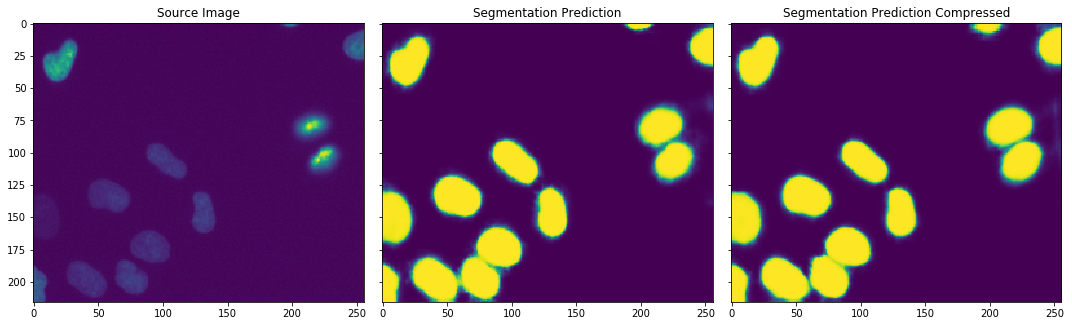

In [38]:
import matplotlib.pyplot as plt
print(test_images_fgbg.shape)

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(test_images_fgbg_compressed[index, ..., 1])
ax[2].set_title('Segmentation Prediction Compressed')

fig.tight_layout()
plt.show()